# 6장 결정트리

## 주요 내용

- 결정트리 `분류모델` 작동법
- CART: 결정트리 알고리즘
- 결정트리 `회귀모델` 작동법

## 기본 설정

In [1]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 6.1 결정트리 학습과 시각화

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier # 결정트리 알고리즘을 활용한 분류 모델을 지원

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42) # 가지분할을 최대 2번까지만 허용
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

__주의사항: *아래 코드는 파이썬 3.8을 사용하는 경우 필요한 모듈을 설치할 수 없기에 실행하지 말아야 한다. 이어지는 코드의 실행과는 무관한 그래프 지원 보조코드이다. 하만 다행이도 파썬 3.7 버전을 사용하는 구글 코랩에서는 잘 실행된다.*__

아래 코드는 `graphviz` 모듈의 기능을 이용하여 학습된 결정트리 분류모델의 훈련결과를 보여준다.
각각의 노드(node)에서 훈련과정에 사용된 값과 속성을 확인할 수 있다.

- 첫째줄: 노드 분할과정에 사용된 특성과 특성 임곗값
- `gini`: 노드의 지니 불순도
- `samples`: 노드에 포함된 훈련 샘플 개수
- `value`: 노드에 포함된 샘플들의 클래스 비율
- `class`: 가장 높은 비율의 클래스. 동율이면 작은 인덱스의 클래스 지정

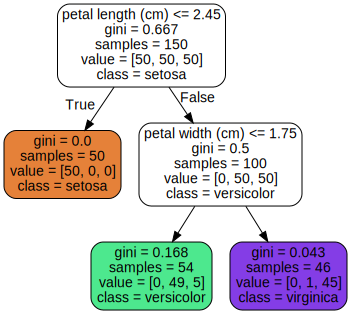

In [3]:
# 파이썬 3.8인 경우 실행하지 말것.
# 현재(2021년 5월) 구글 코랩에서는 잘 실행됨.

from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# 6.2 예측하기

**식 6-1: 지니 불순도**
* 예로 위의 gini = 0.168의 경우? value=[0,49,5]이고, 전체 샘플 54개 이므로
* 1-((0/54)^2 + (49/54)^2 + (5/54)^2)

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


**식 6-2: 분류에 대한 CART 비용(=손실) 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

In [4]:
# 결정트리 분류 모델의 클래스 예측결과를 그래프로 그린다.

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

아래 코드는 가지분할을 최대 3번까지 허용해서 얻어진 모델의 훈련샘플들에 대한 예측결과를 보여준다.

- 1차 분할 기준: 꽃잎 길이=2.45cm
- 2차 분할 기준: 꽃잎 너비=1.75cm
- 3차 분할 기준: (우상단) 꽃잎 길이=4.85cm, (우하단) 꽃잎 길이=4.95cm

Saving figure decision_tree_decision_boundaries_plot


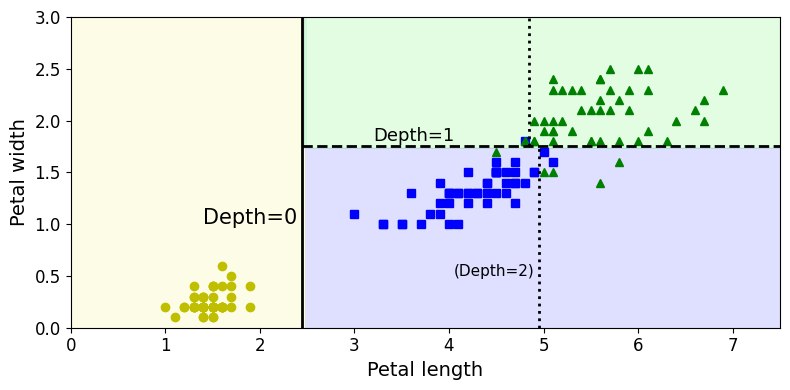

In [5]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)

plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)        # 1차 분할 기준선
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)  # 2차 분할 기준선
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)     # 3차 분할 기준선 (우하단)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)     # 3차 분할 기준선 (우상단)

plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

__주의사항: *아래 코드는 파이썬 3.8을 사용하는 경우 필요한 모듈을 설치할 수 없기에 실행하지 말아야 한다. 이어지는 코드의 실행과는 무관한 그래프 지원 보조코드이다.*__

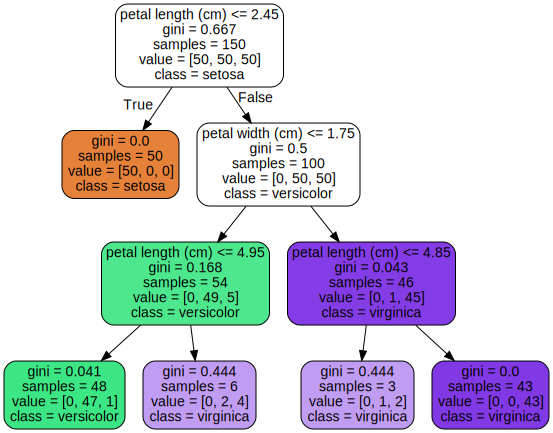

In [ ]:
# 파이썬 3.8인 경우 실행하지 말것.

tree_clf_d3 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_d3.fit(X, y)

export_graphviz(
        tree_clf_d3,
        out_file=os.path.join(IMAGES_PATH, "iris_tree_d3.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_d3.dot"))

### 화이트박스 vs. 블랙박스

결정트리 모델처럼 훈련과 예측 과정은 명료하게 추적할 수 있는 모델을 화이트박스(white box) 모델이라 부른다. 
반면에 앞으로 다룰 예정인 랜덤 포레스트, 신경망 등의 모델은 블랙박스(black box) 모델이라 부른다. 
이유는 해당 모델들의 훈련과 예측 과정을 정확히 설명할 수 없기 때문이다.

# 6.3 클래스 확률 추정

입력 샘플의 클래스 확률은 샘플이 속한 리프 노드(leaf node)의 클래스 비율을 사용하며,
가장 높은 비율의 클래스를 예측값으로 사용한다.
따라서 노드에 속한 모든 샘플의 클래스 확률은 동일하다.

In [6]:
# 꽃잎 길이와 너비가 각각 5cm, 1.5cm인 붗꽃의 품종별 확률과 예측값
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:
tree_clf.predict([[5, 1.5]]) # 버시컬러가 예측됨

array([1])

# 6.7 규제 매개변수

결정트리 모델의 규제는 기본적으로 분할을 제한하는 다양한 방식으로 이루어진다.
아래 코드는 `min_samples_leaf=4` 규제를 사용하는 모델(아래 그림 오른편)과
어느 규제도 사용하지 않은 모델(아래 그림 왼편)의 차이를 보여준다.
사용되는 훈련세트는 moons 데이터셋이다.

- 왼편 결정트리: 과대적합 발생
- 오른편 결정트리: `min_samples_leaf=4` 규제 사용. 즉, 리프노드에 최소 4개 이상의 샘플이 포함되어 있어야 함.

Saving figure min_samples_leaf_plot


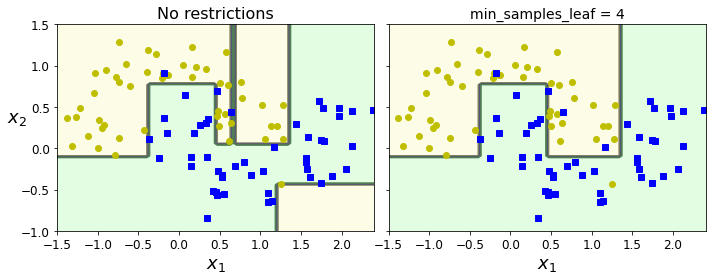

In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)  # 규제 없음
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)  # 규제 사용
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

# 6.8 회귀

결정트리 회귀모델 알고리즘은 분류모델과 거의 동일한 알고리즘을 사용한다.<br>
아래 코드는 2차 다항식을 이용하여 생성된 훈련 세트에 대한 `결정트리 회귀모델 훈련`을 보여준다.

In [9]:
# 2차 다항식 훈련세트 + 잡음
np.random.seed(42)

m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

아래 코드는 `max_depth`를 2 또는 3으로 지정하고 결정트리 회귀모델을 훈련시킨 결과를 보여준다.

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)  # max_depth=2
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)  # max_depth=3
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

아래 함수는 훈련세트와 노드별 예측값(빨강 직선)을 그린다. 

In [11]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

Saving figure tree_regression_plot


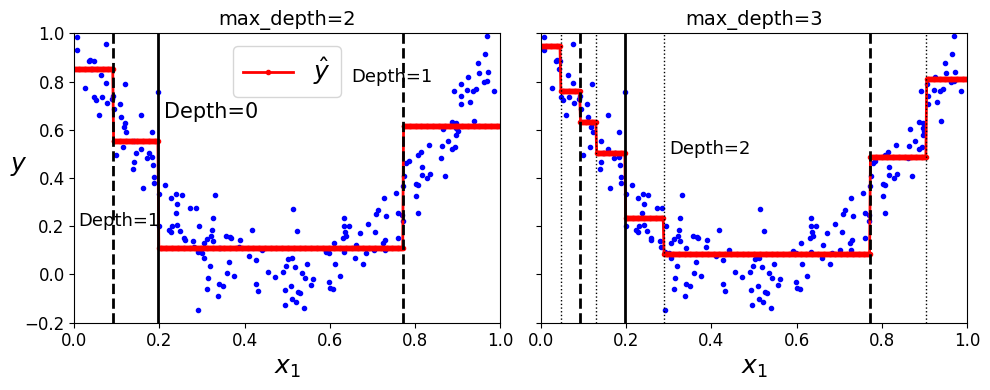

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

# 오른편 그림
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

# 왼편 그림: `max_depth=2`인 경우
# 오른편 그림: `max_depth=3`인 경우 -> 노드분할이 더 일어나니까 더 세밀하게 나타남

왼편 그래프에 해당하는 결정트리 회귀모델은 다음과 같다.

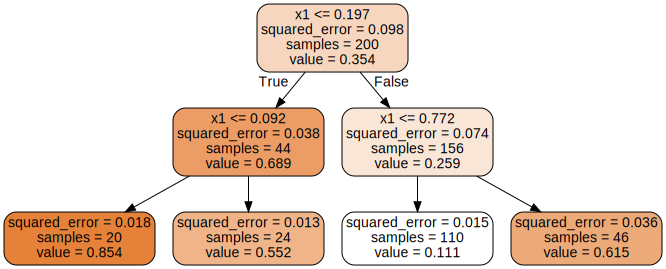

In [13]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

### 회귀모델 규제

결정트리 회귀모델의 규제는
CART 알고리즘이 노드 분할에 사용하는 기준(`criterion`) 하이퍼파라미터에 사용되는 값을 제외하고
분류모델의 경우와 완전히 동일하다. 

- 분류모델의 비용함수 기준: 지니 불순도(`gini`) 또는 엔트로피(`entropy`)
- 회귀모델의 비용함수 기준: 평균제곱오차(`mse`), 프리드먼 평균제곱오차(`friedman_mse`), 
    평균절대오차(`mae`), 쁘와송(`poisson`)

아래 코드는 `min_samples_leaf=10` 규제를 사용하는 회귀모델(아래 그림 오른편)과
어느 규제도 사용하지 않은 회귀모델(아래 그림 왼편)의 차이를 보여준다.

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) # 규제
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

Saving figure tree_regression_regularization_plot


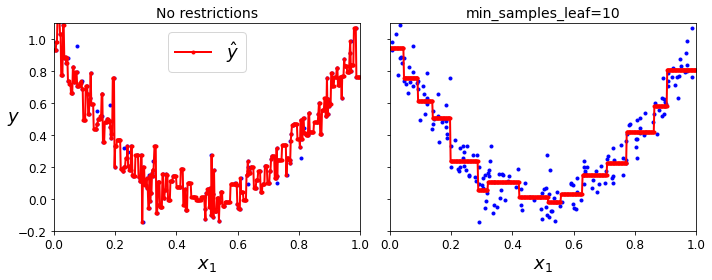

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

# 오른편 그림
plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 왼편 결정트리: 과대적합 발생 (규제 사용 X)
# 오른편 결정트리: `min_samples_leaf=10` 규제 사용. 즉, 리프노드에 최소 10개 이상의 샘플이 포함되어 있어야 함.

# 6.9 불안정성

결정트리 모델의 훈련과 사용은 매우 쉽고, 성능도 강력하다.
하지만 x, y 등의 축(axis)에 수직인 결정경계만 사용하기 때문에 회전, 샘플 삭제/추가 등 훈련세트의 작은 변화에
매우 민감하다. 

### 회전 민감도 예제 1

아래 코드는 결정트리 모델의 회전 민감도를 보여준다.
두 개의 특성을 가지며, 임의로 생성된 100개의 훈련 샘플을 시계방향으로 45도 회전시킨 후
훈련시킨 모델의 결정경계가 직선에서 계단식으로 변화되는 것을 볼 수 있다.
결국 일반화 성능이 보다 약한 모델이 생성되었다.

- 두 개의 특성을 갖는 100개의 훈련 샘플 생성. 둘째 특성값의 부호에 따라 두 클래스로 분류.

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

- 시계방향으로 45도 회전시키기

In [ ]:
angle = np.pi / 4  # 회전 각도 45

# 훈련 세트 회전시키기
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

* 결정트리 모델 비교

Saving figure sensitivity_to_rotation_plot


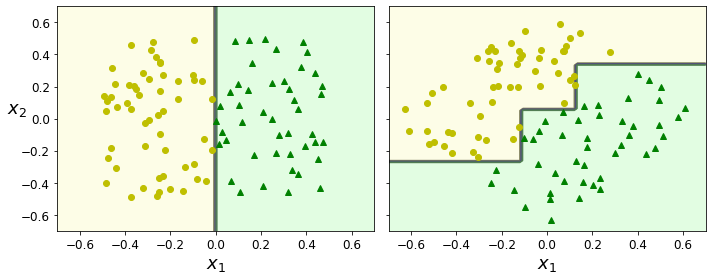

In [ ]:
# 왼편 그래프 모델
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)

# 오른편 그래프 모델
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# 왼편 그래프
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

# 오른편 그래프 => 45도 회전한 것
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

### 회전 민감도 예제 2

아래 코드는 붗꽃 데이터를 시계방향으로 20도 회전한 후에 훈련시키면 분류 모델의 결정경계가
이전과 많이 다름을 잘 보여준다.

In [ ]:
# 붓꽃 데이터 다시 불러오기
iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

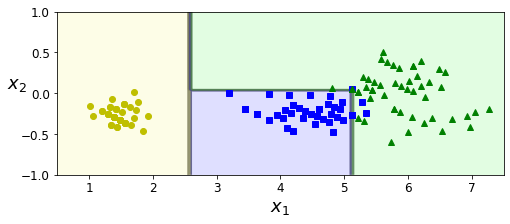

In [ ]:
# 시계방향으로 20도 회전
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

### 샘플 민감도 예제

아래 코드는 훈련세트에 포함된 버시컬러 품종 중에서 가장 넓은 꽃잎을 가진
샘플을 삭제한 후에 훈련시킨 결정트리 분류모델의 결정경계를 보여준다.
이전과 많이 다름에 주의하라.

- 버시컬러 샘플 중 가장 넓은 꽃잎 너비 확인: 1.8cm

In [ ]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # 가장 넓은 꽃잎을 갖는 버시컬러 샘플의 특성 확인

array([[4.8, 1.8]])

- 가장 넓은 버시컬러 샘플 제거 후 훈련

In [ ]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)  # y==2는 버지니카 품종은 그대로 둠.

X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

결정경계 기준값으로 꽃잎의 길이는 전혀 사용되지 않는다.

Saving figure decision_tree_instability_plot


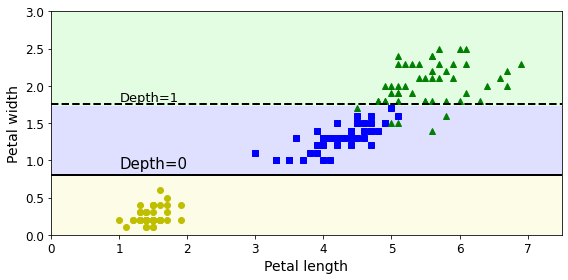

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()